# Skin Lesion Classification of Dermoscopic Images using Machine Learning and 
# Convolutional Neural Network

## Data Organisation

In [1]:
import os
import shutil
import pandas as pd

# Define paths
dataset_paths = [
    "C:/Users/bylrs/Downloads/HAM10000_images_part_1",  # Dataset path 1
    "C:/Users/bylrs/Downloads/HAM10000_images_part_2"   # Dataset path 2
]
output_path = "C:/Users/bylrs/Downloads/structured"
csv_path = "C:/Users/bylrs/Downloads/HAM10000_metadata.csv"  # Path to labels.csv

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Function to find an image across multiple dataset paths
def find_image(image_id, dataset_paths):
    for path in dataset_paths:
        image_path = os.path.join(path, image_id + ".jpg")
        if os.path.exists(image_path):
            return image_path
    return None

# Organize images based on the 'dx' column (disease type)
def organize_dataset_from_csv(dataset_paths, output_path, df):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for _, row in df.iterrows():
        image_id = row['image_id']  # Image name without extension
        dx = row['dx']  # Disease type (class)

        # Define class folder path
        class_path = os.path.join(output_path, dx)
        if not os.path.exists(class_path):
            os.makedirs(class_path)

        # Find the image across dataset paths
        src = find_image(image_id, dataset_paths)
        if src:
            dst = os.path.join(class_path, os.path.basename(src))
            shutil.copy(src, dst)
        else:
            print(f"Warning: {image_id}.jpg not found in any dataset path!")

# Organize the dataset
organize_dataset_from_csv(dataset_paths, output_path, df)
print("Dataset organized successfully!")


Dataset organized successfully!


In [6]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Define paths
data_path = "C:/Users/bylrs/Downloads/structured"
resize_220_path = "C:/Users/bylrs/Downloads/resized_220x220"
resize_96_path = "C:/Users/bylrs/Downloads/resized_96x96"

# Create directories if they don't exist
os.makedirs(resize_220_path, exist_ok=True)
os.makedirs(resize_96_path, exist_ok=True)

# Resize function
def resize_and_save_images(input_path, output_path, size):
    for class_name in os.listdir(input_path):
        class_folder = os.path.join(input_path, class_name)
        output_class_folder = os.path.join(output_path, class_name)
        os.makedirs(output_class_folder, exist_ok=True)

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path)

            # Resize the image
            img_resized = cv2.resize(img, size)
            
            # Save the resized image
            cv2.imwrite(os.path.join(output_class_folder, img_file), img_resized)

# Resize all images to 220x220 and 96x96
resize_and_save_images(data_path, resize_220_path, (220, 220))
resize_and_save_images(data_path, resize_96_path, (96, 96))

print("Image resizing completed!")


Image resizing completed!


In [8]:
def load_images_to_array(data_path, image_size=(96, 96)):
    images = []
    labels = []

    for class_name in os.listdir(data_path):
        class_folder = os.path.join(data_path, class_name)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path)

            # Normalize pixel values to [0, 1]
            img = img / 255.0
            images.append(img)
            labels.append(class_name)

    # Convert to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)

    return images, labels

# Load the 96x96 resized images
X, y = load_images_to_array(resize_96_path)
print(f"Loaded {len(X)} images.")

# One-hot encode labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)
print(f"Labels after one-hot encoding: {y_encoded[:5]}")


Loaded 10015 images.
Labels after one-hot encoding: [[1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]


## Augumentation

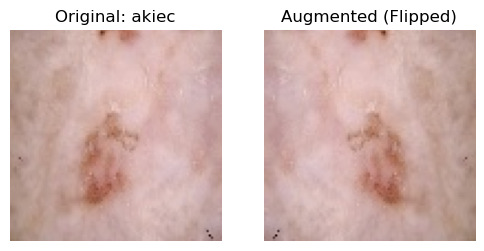

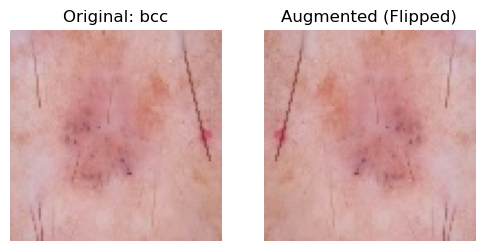

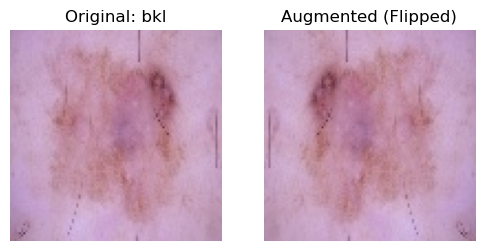

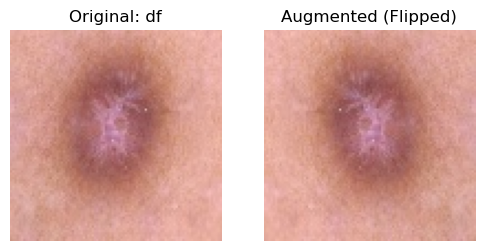

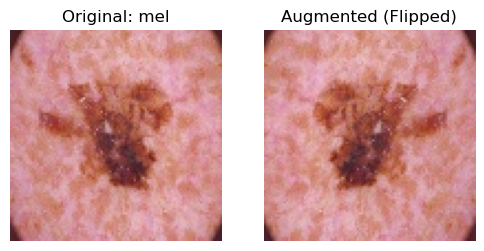

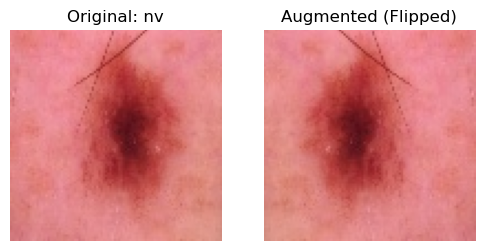

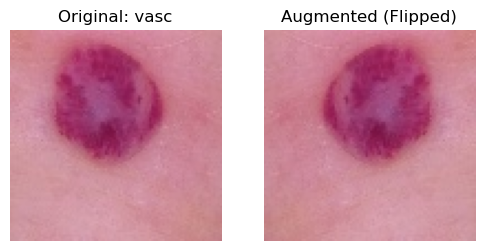

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

def get_first_image_and_flip(base_path):
    """Get the first image from each folder, apply horizontal flip, and display with labels."""
    # Loop through each folder in the base path
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            image_files = [f for f in os.listdir(dir_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

            # Check if there are images in the directory
            if image_files:
                # Get the first image
                first_image_path = os.path.join(dir_path, image_files[0])
                img = cv2.imread(first_image_path)

                if img is not None:
                    # Apply horizontal flip
                    img_flipped = cv2.flip(img, 1)

                    # Convert BGR to RGB for displaying with matplotlib
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_flipped_rgb = cv2.cvtColor(img_flipped, cv2.COLOR_BGR2RGB)

                    # Display the original and flipped images with labels
                    plt.figure(figsize=(6, 5))
                    plt.subplot(1, 2, 1)
                    plt.imshow(img_rgb)
                    plt.title(f'Original: {dir_name}')
                    plt.axis('off')

                    plt.subplot(1, 2, 2)
                    plt.imshow(img_flipped_rgb)
                    plt.title('Augmented (Flipped)')
                    plt.axis('off')

                    plt.show()
                else:
                    print(f"Warning: Unable to load {first_image_path}")

# Update the dataset path with your directory
base_path = "C:/Users/bylrs/Downloads/resized_96x96"  # Use the selected dataset path

# Call the function
get_first_image_and_flip(base_path)

In [12]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Horizontal flip augmentation
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Create augmented data and save images per class
def augment_data_and_save(input_path, output_path, generator, n_samples=200):
    os.makedirs(output_path, exist_ok=True)

    # Iterate over each class directory
    for class_name in os.listdir(input_path):
        class_folder = os.path.join(input_path, class_name)

        # Check if it is a directory
        if os.path.isdir(class_folder):
            output_class_folder = os.path.join(output_path, class_name)
            os.makedirs(output_class_folder, exist_ok=True)

            # Load images for augmentation
            img_files = os.listdir(class_folder)[:n_samples]  # Take only the first n_samples images
            
            for img_file in img_files:
                img_path = os.path.join(class_folder, img_file)
                
                # Read the image
                img = cv2.imread(img_path)
                if img is not None:  # Ensure the image is read correctly
                    img = cv2.resize(img, (96, 96))  # Resize to 96x96
                    img = np.expand_dims(img, 0)  # Add batch dimension

                    # Generate and save augmented images
                    i = 0
                    for batch in generator.flow(img, batch_size=1, save_to_dir=output_class_folder, 
                                                save_prefix='aug', save_format='jpg'):
                        i += 1
                        if i >= n_samples:
                            break  # Stop after generating n_samples

# Paths
resize_96_path = "C:/Users/bylrs/Downloads/resized_96x96"  # Path to resized images
augmented_path = "C:/Users/bylrs/Downloads/augmented"  # Output path for augmented images

# Generate 200 augmented images per class
augment_data_and_save(resize_96_path, augmented_path, flip_gen)
print("Data augmentation completed!")

Data augmentation completed!


In [22]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_path = "C:/Users/bylrs/Downloads/resized_96x96"  # Path to your resized images
labels = []  # To hold the labels
images = []  # To hold the images

# Load images and labels
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (96, 96))  # Resize to 96x96
                images.append(img)
                labels.append(class_name)  # Assuming class_name is the label

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Encode labels (you can use LabelEncoder or OneHotEncoder based on your needs)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert labels to integers

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create an ImageDataGenerator for training
train_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Fit the generator to the training data
train_gen.fit(X_train)

# Define a simple CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Adjust for number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training with data augmentation
model.fit(train_gen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_test, y_test))


C:\Users\bylrs\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\bylrs\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 75s 279ms/step - accuracy: 0.6126 - loss: 34.5652 - val_accuracy: 0.6790 - val_loss: 0.9415
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.6757 - loss: 0.9628 - val_accuracy: 0.6540 - val_loss: 0.9339
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.6703 - loss: 0.9692 - val_accuracy: 0.6610 - val_loss: 0.9661
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 304ms/step - accuracy: 0.6738 - loss: 0.9236 - val_accuracy: 0.6595 - val_loss: 0.9313
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 74s 296ms/step - accuracy: 0.6783 - loss: 0.8918 - val_accuracy: 0.6580 - val_loss: 0.9618
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 300ms/step - accuracy: 0.6787 - loss: 0.9063 - val_accuracy: 0.6640 - val_loss: 0.9329
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 290ms/step - accuracy: 0.6833 - loss: 0.8575 - val_accuracy: 0.6805 - val_loss: 0.8952
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 84s 296ms/step - accuracy: 0.6829 - loss: 

In [24]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os

# Base path where your dataset is located
base_path = "C:/Users/bylrs/Downloads/resized_96x96"

# Initialize lists for paths and labels
image_paths = []
labels = []

# Loop through each disease folder
for class_name in os.listdir(base_path):
    class_folder = os.path.join(base_path, class_name)
    
    # Check if it's a directory
    if os.path.isdir(class_folder):
        # Loop through each image file in the class folder
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            image_paths.append(img_path)  # Add the image path
            labels.append(class_name)      # Add the corresponding label (class name)

# Now image_paths contains paths to all images, and labels contains their respective classes
output_file = 'features.h5'


In [33]:
import skimage
print(skimage.__version__)

0.23.2


In [4]:
import os
import shutil

def copy_first_n_images(source_base_path, destination_base_path, n=100):
    """Copy the first n images from each subfolder in the source base path to the destination path."""
    
    # Create the destination base path if it does not exist
    if not os.path.exists(destination_base_path):
        os.makedirs(destination_base_path)
    
    # Iterate through each folder in the source base path
    for folder_name in os.listdir(source_base_path):
        folder_path = os.path.join(source_base_path, folder_name)
        
        if os.path.isdir(folder_path):
            # Create a corresponding folder in the destination path
            dest_folder_path = os.path.join(destination_base_path, folder_name)
            if not os.path.exists(dest_folder_path):
                os.makedirs(dest_folder_path)
            
            # Get all image files in the folder
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            
            # Copy the first n images to the destination folder
            for img_file in image_files[:n]:
                src_img_path = os.path.join(folder_path, img_file)
                dest_img_path = os.path.join(dest_folder_path, img_file)
                shutil.copy(src_img_path, dest_img_path)
                print(f"Copied {img_file} to {dest_folder_path}")

# Define the source and destination paths
source_path = "C:/Users/bylrs/Downloads/resized_96x96"  # Original dataset path
destination_path = "C:/Users/bylrs/Downloads/selected_96x96"  # Path to save selected images

# Call the function to copy the first 100 images from each folder
copy_first_n_images(source_path, destination_path, n=100)

print("Image selection completed!")

Copied ISIC_0024329.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024372.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024418.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024450.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024463.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024468.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024470.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024511.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024517.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024522.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024539.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024562.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024575.jpg to C:/Users/bylrs/Downloads/selected_96x96\akiec
Copied ISIC_0024579.jpg to C:/Users/bylrs/Downloads

## Model Evaluation 

In [8]:
import os
import cv2
import numpy as np
import mahotas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time

def extract_features(image_path):
    """Extracts color histogram, Hu moments, and Haralick texture from an image."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Unable to load {image_path}")
        return None, None

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Color Histogram (8x8x8 bins)
    color_hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    color_hist = cv2.normalize(color_hist, color_hist).flatten()

    # Hu Moments
    moments = cv2.HuMoments(cv2.moments(img_gray)).flatten()

    # Haralick Texture
    haralick = mahotas.features.haralick(img_gray).mean(axis=0)

    # Concatenate features
    features = np.hstack([color_hist, moments, haralick])
    label = os.path.basename(os.path.dirname(image_path))
    return features, label

def load_dataset(base_path):
    """Loads images and extracts their features and labels sequentially."""
    features, labels = [], []
    
    start_time = time.time()  # Start the timer

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                feature_vector, label = extract_features(img_path)
                if feature_vector is not None:
                    features.append(feature_vector)
                    labels.append(label)

    end_time = time.time()  # End the timer
    print(f"Feature extraction completed in {end_time - start_time:.2f} seconds.")

    return np.array(features), np.array(labels)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Train a model and evaluate its performance."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall, f1  # Return metrics

# Define the models to be evaluated
models = {
    "Logistic Regression": LogisticRegression(random_state=9, max_iter=200),  # Increased max_iter
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(solver='svd'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=0),
    "Gaussian Naive Bayes": GaussianNB(var_smoothing=1e-09),
    "Support Vector Machine": SVC(kernel='linear', C=1, random_state=0)
}

# Update the dataset path with your directory
base_path = "C:/Users/bylrs/Downloads/selected_96x96"  # Use the selected dataset path

# Load dataset
X, y = load_dataset(base_path)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Store results for plotting
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Train and evaluate each model sequentially
for name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    
    # Append results to the dictionary
    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)

    # Print the results for each model
    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}\n")

print("Model evaluation completed!")

Feature extraction completed in 15.99 seconds.
Logistic Regression Results:
  Accuracy: 0.4429
  Precision: 0.4517
  Recall: 0.4429
  F1-Score: 0.4439

Linear Discriminant Analysis Results:
  Accuracy: 0.1429
  Precision: 0.1753
  Recall: 0.1429
  F1-Score: 0.1204

K-Nearest Neighbors Results:
  Accuracy: 0.3643
  Precision: 0.3876
  Recall: 0.3643
  F1-Score: 0.3653

Decision Tree Results:
  Accuracy: 0.3643
  Precision: 0.3801
  Recall: 0.3643
  F1-Score: 0.3665

Random Forest Results:
  Accuracy: 0.5643
  Precision: 0.5912
  Recall: 0.5643
  F1-Score: 0.5616

Gaussian Naive Bayes Results:
  Accuracy: 0.3571
  Precision: 0.4015
  Recall: 0.3571
  F1-Score: 0.3265

Support Vector Machine Results:
  Accuracy: 0.4357
  Precision: 0.4398
  Recall: 0.4357
  F1-Score: 0.4353

Model evaluation completed!


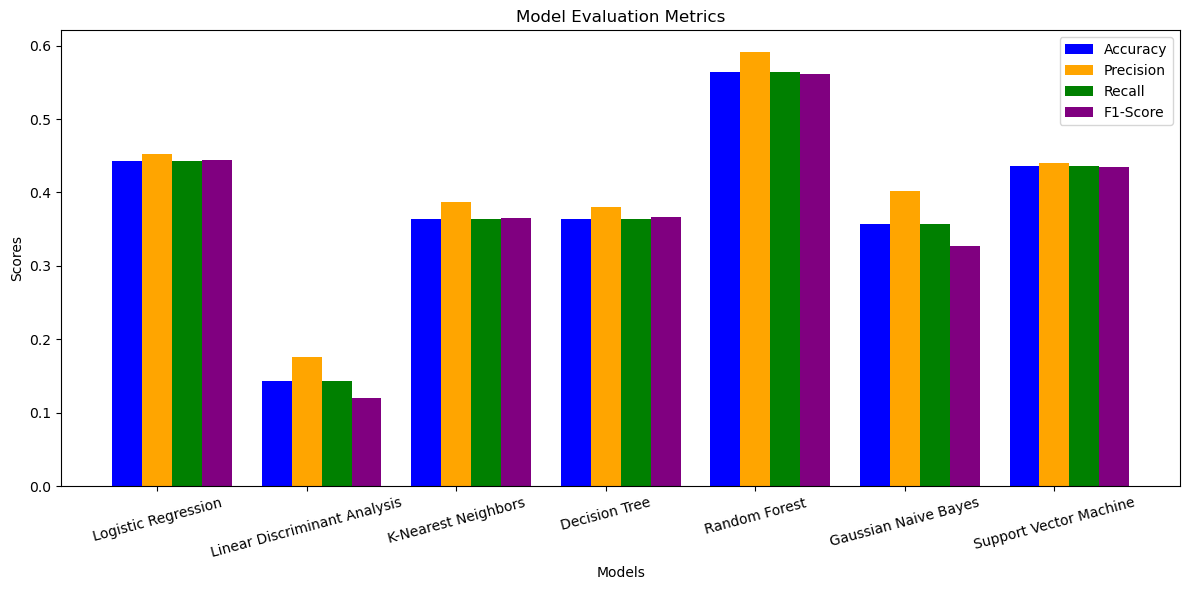

In [10]:
import matplotlib.pyplot as plt

# Plotting the results in a separate cell
plt.figure(figsize=(12, 6))

# Set up bar width and positions
bar_width = 0.2
x = np.arange(len(results["Model"]))

# Create bar plots for each metric
plt.bar(x - bar_width, results["Accuracy"], width=bar_width, label='Accuracy', color='blue')
plt.bar(x, results["Precision"], width=bar_width, label='Precision', color='orange')
plt.bar(x + bar_width, results["Recall"], width=bar_width, label='Recall', color='green')
plt.bar(x + 2 * bar_width, results["F1-Score"], width=bar_width, label='F1-Score', color='purple')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.xticks(x, results["Model"], rotation=15)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

## CNN

In [39]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Function to load images and their labels
def load_dataset(base_path, img_size=(96, 96)):
    """Loads images from directory and resizes them."""
    images, labels = [], []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(os.path.basename(root))  # Directory name as label

    return np.array(images), np.array(labels)

# Update the dataset path with your directory
base_path = "C:/Users/bylrs/Downloads/selected_96x96"  # Use the selected dataset path

# Load dataset
X, y = load_dataset(base_path)

# Normalize images
X = X.astype('float32') / 255.0

# Convert labels to numerical values
classes, y_numeric = np.unique(y, return_inverse=True)

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_datagen.fit(X_train)

# Build CNN Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))  # Output layer with number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=20)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=classes))


Epoch 1/20


C:\Users\bylrs\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.1584 - loss: 2.0151 - val_accuracy: 0.2357 - val_loss: 1.8769
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.2297 - loss: 1.8658 - val_accuracy: 0.2071 - val_loss: 1.9084
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.2240 - loss: 1.8426 - val_accuracy: 0.2857 - val_loss: 1.7670
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.2592 - loss: 1.7992 - val_accuracy: 0.3214 - val_loss: 1.7223
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3183 - loss: 1.6987 - val_accuracy: 0.3500 - val_loss: 1.6908
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3355 - loss: 1.6585 - val_accuracy: 0.3786 - val_loss: 1.7253
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.4047 - loss: 1.5690 - val_accuracy: 0.3786 - val_loss: 1.6412
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.4196 - loss: 1.5632 - val_accuracy: 0.4071 - val_loss: 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


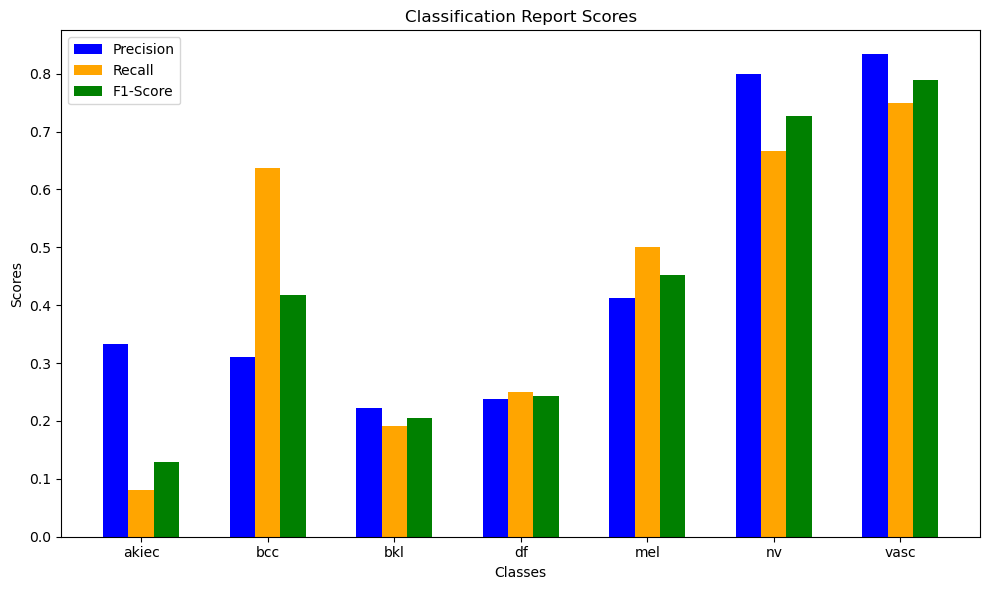

In [41]:
import matplotlib.pyplot as plt

# Generate classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)

# Prepare data for plotting
labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

# Set up bar width and positions
bar_width = 0.2
x = np.arange(len(labels))

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='blue')
plt.bar(x, recall, width=bar_width, label='Recall', color='orange')
plt.bar(x + bar_width, f1_score, width=bar_width, label='F1-Score', color='green')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Classification Report Scores')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\bylrs\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\bylrs\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.2064 - loss: 184.3810 - val_accuracy: 0.2429 - val_loss: 2.1220
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.2949 - loss: 1.7891 - val_accuracy: 0.2714 - val_loss: 2.0332
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.3198 - loss: 1.7345 - val_accuracy: 0.2857 - val_loss: 2.0759
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - accuracy: 0.4133 - loss: 1.7132 - val_accuracy: 0.3786 - val_loss: 1.9086
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.3879 - loss: 1.6747 - val_accuracy: 0.3714 - val_loss: 1.8492
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.3650 - loss: 1.6686 - val_accuracy: 0.3929 - val_loss: 1.9323
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.3777 - loss: 1.6167 - val_accuracy: 0.3357 - val_loss: 1.8640
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.4395 - loss: 1.5456 - val_accuracy: 

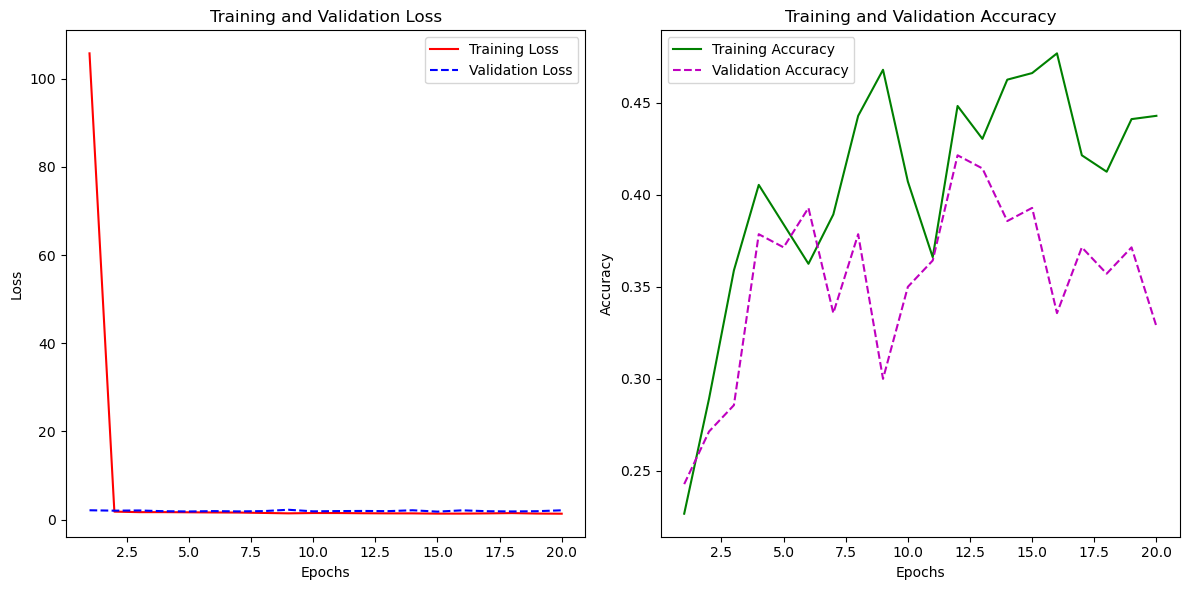

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define paths
data_path = "C:/Users/bylrs/Downloads/MIA_Skin Lesions/selected_96x96"  # Path to your resized images
labels = []  # To hold the labels
images = []  # To hold the images

# Load images and labels
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (96, 96))  # Resize to 96x96
                images.append(img)
                labels.append(class_name)  # Assuming class_name is the label

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create an ImageDataGenerator for training
train_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Fit the generator to the training data
train_gen.fit(X_train)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Adjust for number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(train_gen.flow(X_train, y_train, batch_size=32), 
                    epochs=20, validation_data=(X_test, y_test))

# Plotting Loss and Accuracy
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'b--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'g-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'm--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the graph
plot_history(history)
